# Experiments to improve classification accuracy &ndash; merged-average baseline

This notebook contains experiments to improve classification accuracy that use the merged-average profile with all languages as a baseline, ignoring results on other profiles.

In [1]:
from IPython.display import display
import pandas as pd
import pylab
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

pylab.rcParams['figure.figsize'] = (10, 5)

## Looking at the new baseline results

In [2]:
LANGUAGE_CODE_TO_NAME = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'bg': 'Bulgarian',
    'bn': 'Bengali',
    'ca': 'Catalan',
    'cs': 'Czech',
    'da': 'Danish',
    'de': 'German',
    'el': 'Greek',
    'en': 'English',
    'es': 'Spanish',
    'et': 'Estonian',
    'fa': 'Persian',
    'fi': 'Finnish',
    'fr': 'French',
    'gu': 'Gujarati',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hr': 'Croatian',
    'hu': 'Hungarian',
    'id': 'Indonesian',
    'it': 'Italian',
    'ja': 'Japanese',
    'kn': 'Kannada',
    'ko': 'Korean',
    'lt': 'Lithuanian',
    'lv': 'Latvian',
    'mk': 'Macedonian',
    'ml': 'Malayalam',
    'mr': 'Marathi',
    'ne': 'Nepali',
    'nl': 'Dutch',
    'no': 'Norwegian',
    'pa': 'Punjabi',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'si': 'Sinhalese',
    'sk': 'Slovak',
    'sl': 'Slovene',
    'so': 'Somali',
    'sq': 'Albanian',
    'sv': 'Swedish',
    'sw': 'Swahili',
    'ta': 'Tamil',
    'te': 'Telugu',
    'th': 'Thai',
    'tl': 'Tagalog',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'ur': 'Urdu',
    'vi': 'Vietnamese',
    'zh-cn': 'Simplified Chinese',
    'zh-tw': 'Traditional Chinese'
}

RESULT_PARAM_COLS = ['datasetName', 'substringLength', 'sampleSize', 'profileParam', 'useAllLanguages']

In [3]:
def read_results(path):
    """
    Read results from the given path, dropping all results except for merged-average on all languages.
    """
    results = pd.read_csv(path)
    return results[(results['profileParam'] == 'merged-average') & results['useAllLanguages']]

baseline_results = read_results(
    '../src/test/resources/org/xbib/elasticsearch/index/mapper/langdetect/accuracies.csv'
)
baseline_results.T.head(10).T.head()

,datasetName,substringLength,sampleSize,profileParam,useAllLanguages,af,ar,bg,bn,ca
3,udhr,0,1,merged-average,True,1,1,1,1,1
9,udhr,5,100,merged-average,True,0.35,0.87,0.39,1,0.15
15,udhr,10,100,merged-average,True,0.6,0.98,0.58,1,0.45
21,udhr,20,100,merged-average,True,0.77,0.99,0.84,1,0.73
27,udhr,50,100,merged-average,True,0.97,1,0.92,1,0.97


In [4]:
def extract_accuracies(results, short_only):
    if short_only:
        results = results[results['substringLength'].isin({5, 10, 20})]
    accuracies = results.drop(RESULT_PARAM_COLS, axis=1)
    accuracies.rename_axis({k: '{} ({})'.format(v, k) for k, v in LANGUAGE_CODE_TO_NAME.items()},
                           axis=1, inplace=True)
    return accuracies

def plot_accuracy_deltas_by_language(baseline_results, experiment_results, experiment_name='N/A',
                                     order='median', baseline_desc=None, quiet=False, short_only=True):
    baseline_accuracies = extract_accuracies(baseline_results, short_only)
    experiment_accuracies = extract_accuracies(experiment_results, short_only)
    assert len(baseline_accuracies) == len(experiment_accuracies)
    baseline_accuracies.index = experiment_accuracies.index
    deltas = (experiment_accuracies - baseline_accuracies).dropna(axis=1, how='all')
    delta_counts = pd.Series({k: v.sum().sum() for k, v in dict(positive=deltas > 0,
                                                                negative=deltas < 0,
                                                                zero=deltas == 0).items()})
    delta_means = deltas.mean()
    delta_mean_counts = pd.Series(dict(positive=(delta_means > 0).sum(),
                                       negative=(delta_means < 0).sum(),
                                       zero=(delta_means == 0).sum()))
    count_summary_df = pd.DataFrame({
        'Delta count': delta_counts,
        'Delta percent': delta_counts / delta_counts.sum(),
        'Language mean delta count': delta_mean_counts,
        'Language mean delta percent': delta_mean_counts / delta_mean_counts.sum()
    })
    mean_delta = deltas.mean().mean()
    if quiet:
        return count_summary_df, mean_delta
    print('Result summary (positive is better than the baseline)\n')
    print('Number of results: {}'.format(delta_counts.sum()))
    print('Number of languages: {}'.format(len(deltas.columns)))
    print('Mean delta: {:4f}'.format(mean_delta))
    display(count_summary_df)

    if order == 'width':
        order_series = deltas.max() - deltas.min()
    else:
        order_series = getattr(deltas, order)()
    ax = deltas[order_series.sort_values(ascending=False).index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    positive_limit = deltas.abs().max().max() + 0.01
    # Keep the x-axis symmetrical
    ax.set_xlim((-positive_limit, positive_limit))
    ax.set_xlabel('Accuracy delta')
    ax.set_ylabel('Language')
    ax.set_title('{} Accuracy deltas to baseline{} by language{}'.format(
        experiment_name,
        ' ({})'.format(baseline_desc) if baseline_desc else '',
        '\nShort texts only: 5-20 characters' if short_only else ''
    ))

## Experiment: lowercase

This experiment replaces uppercase ngrams with lowercase ngrams. The results aren't too exciting, possibly because capitalisation is useful in some cases (e.g., German versus English).

The results don't change by much even when the lowercase classifier results are averaged with that of the original classifier.

In [5]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=lowercase \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/lowercase.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 24.743 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: 0.001473


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,103,0.312121,28,0.509091
positive,88,0.266667,23,0.418182
zero,139,0.421212,4,0.072727


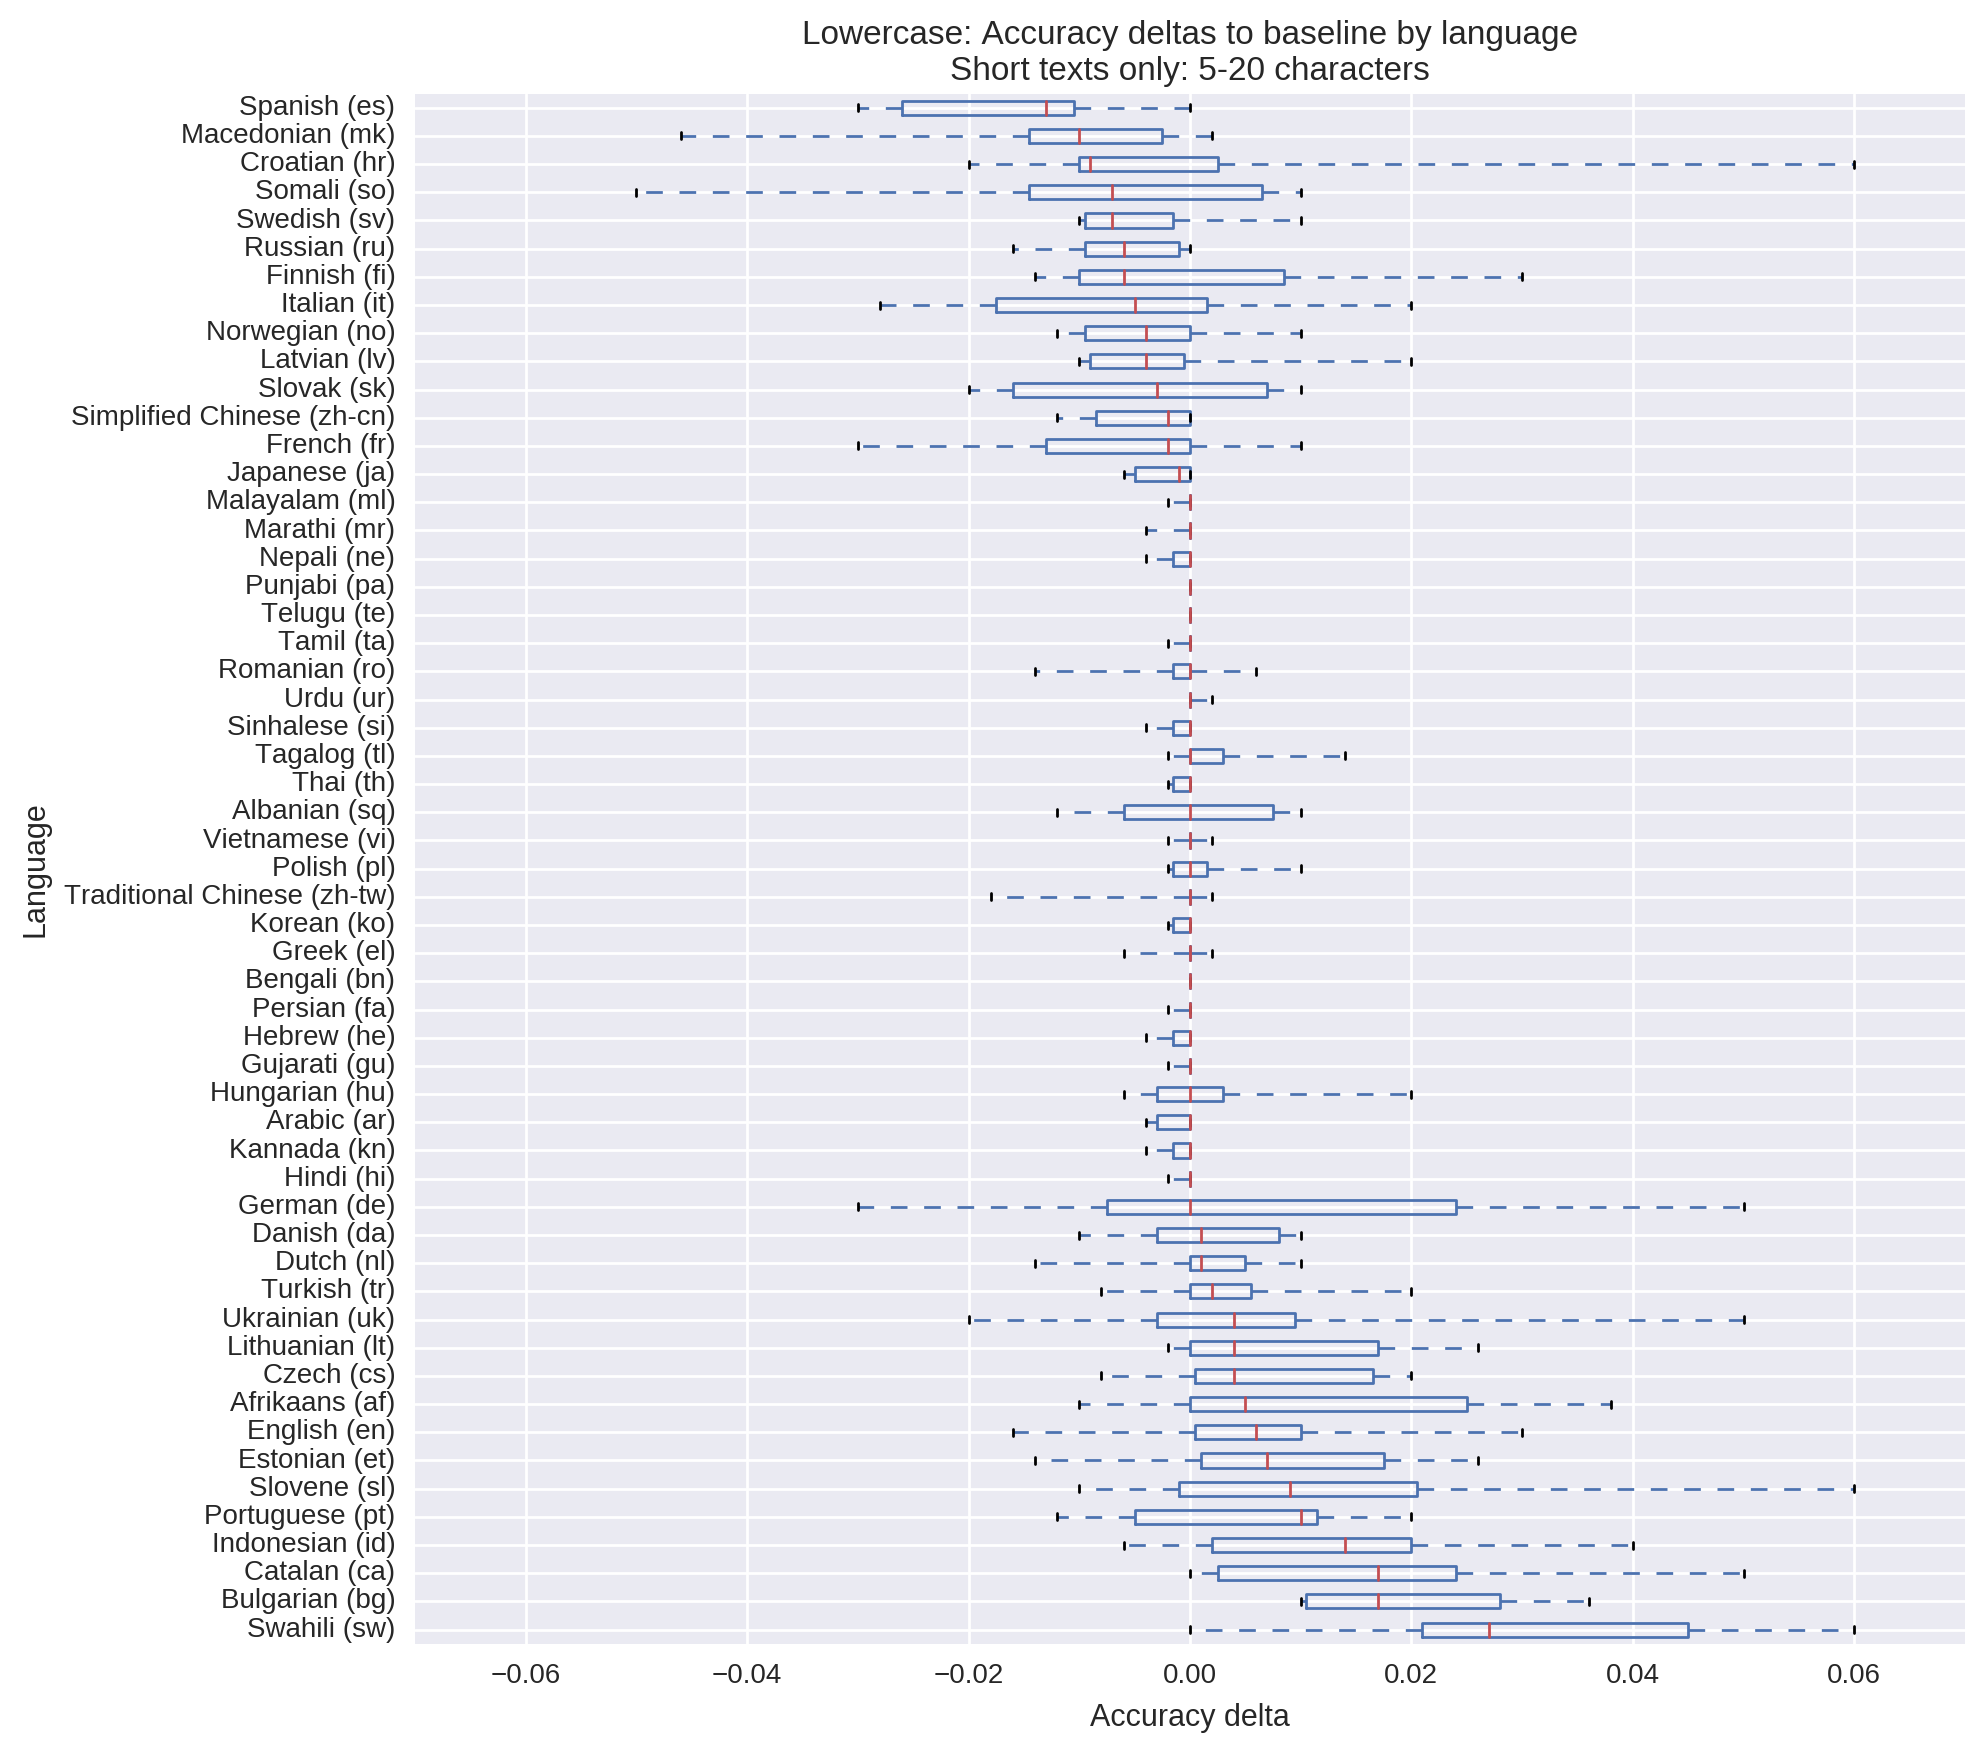

In [6]:
lowercase_results = read_results('results/lowercase.csv')
plot_accuracy_deltas_by_language(baseline_results, lowercase_results, 'Lowercase:')

In [7]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=ensemble-lowercase \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/ensemble-lowercase.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 46.622 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: 0.001776


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,61,0.184848,14,0.254545
positive,100,0.303030,29,0.527273
zero,169,0.512121,12,0.218182


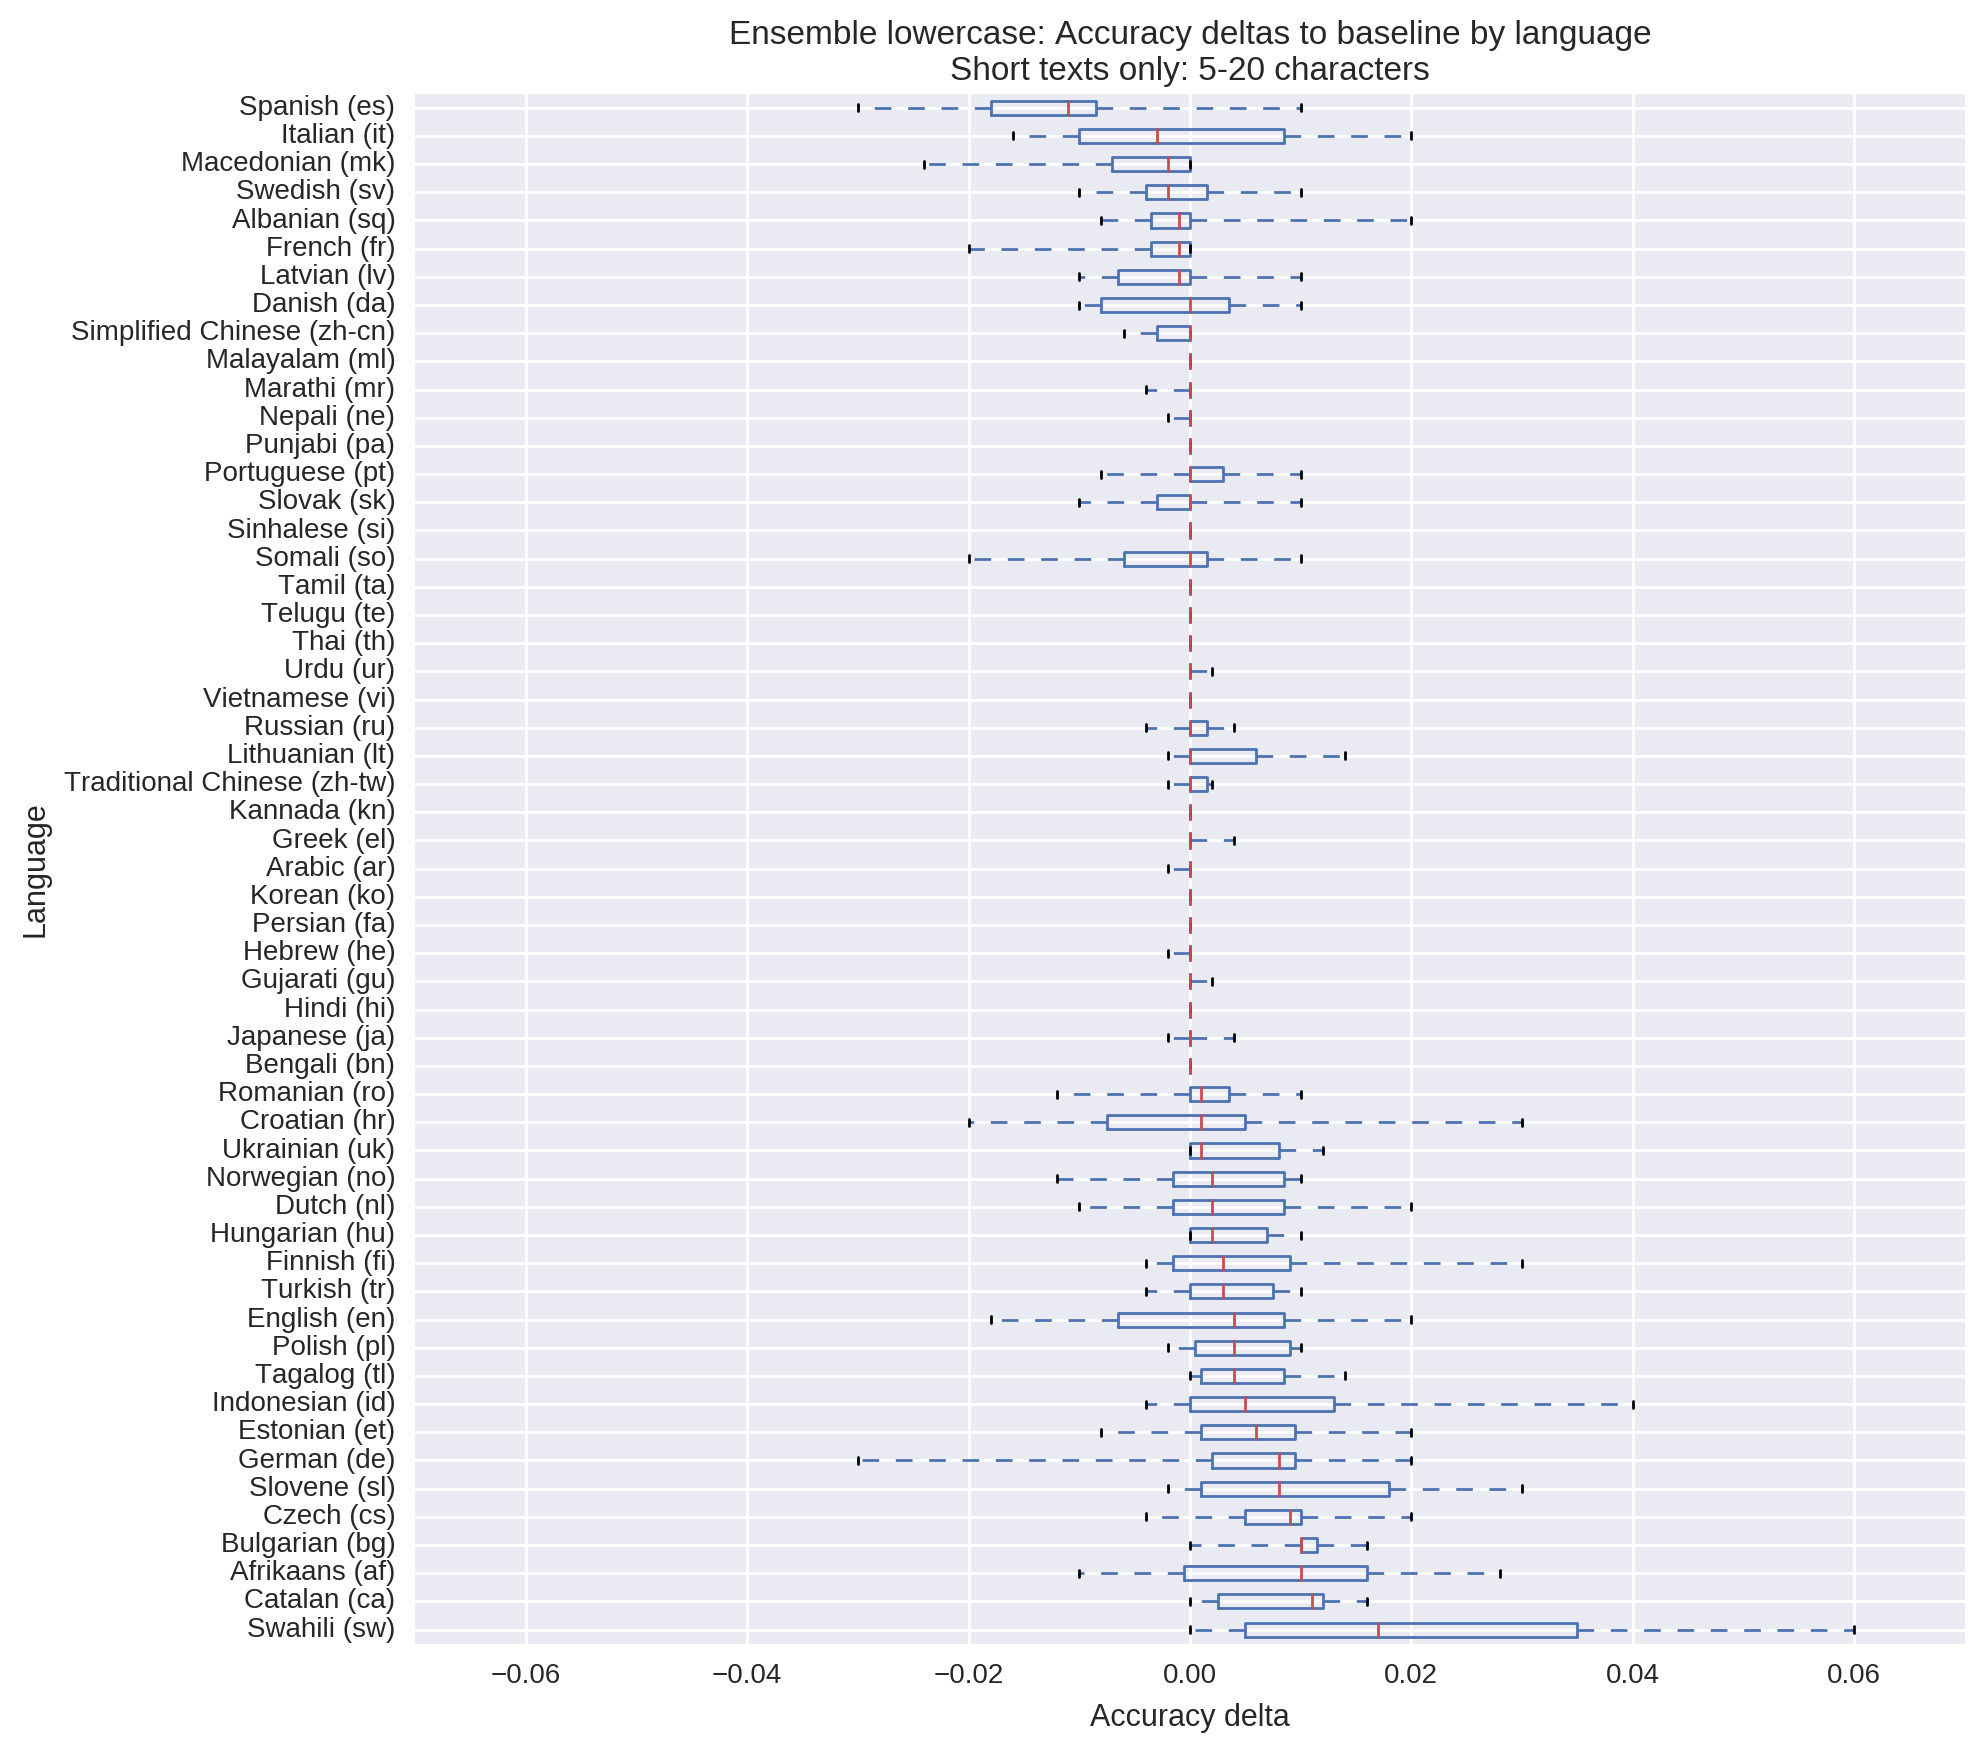

In [8]:
ensemble_lowercase_results = read_results('results/ensemble-lowercase.csv')
plot_accuracy_deltas_by_language(baseline_results, ensemble_lowercase_results, 'Ensemble lowercase:')

## Experiment: one-skip-bigrams

This experiment adds one-skip bigrams extracted from the profile trigrams (e.g., "the" -> "te"). This doesn't do much in terms of positive results, possibly because one-skip bigrams don't encode that much extra information and just add noise.

In [9]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=one-skip-bigrams \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/one-skip-bigrams.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 28.687 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: -0.006103


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,165,0.50000,40,0.727273
positive,65,0.19697,10,0.181818
zero,100,0.30303,5,0.090909


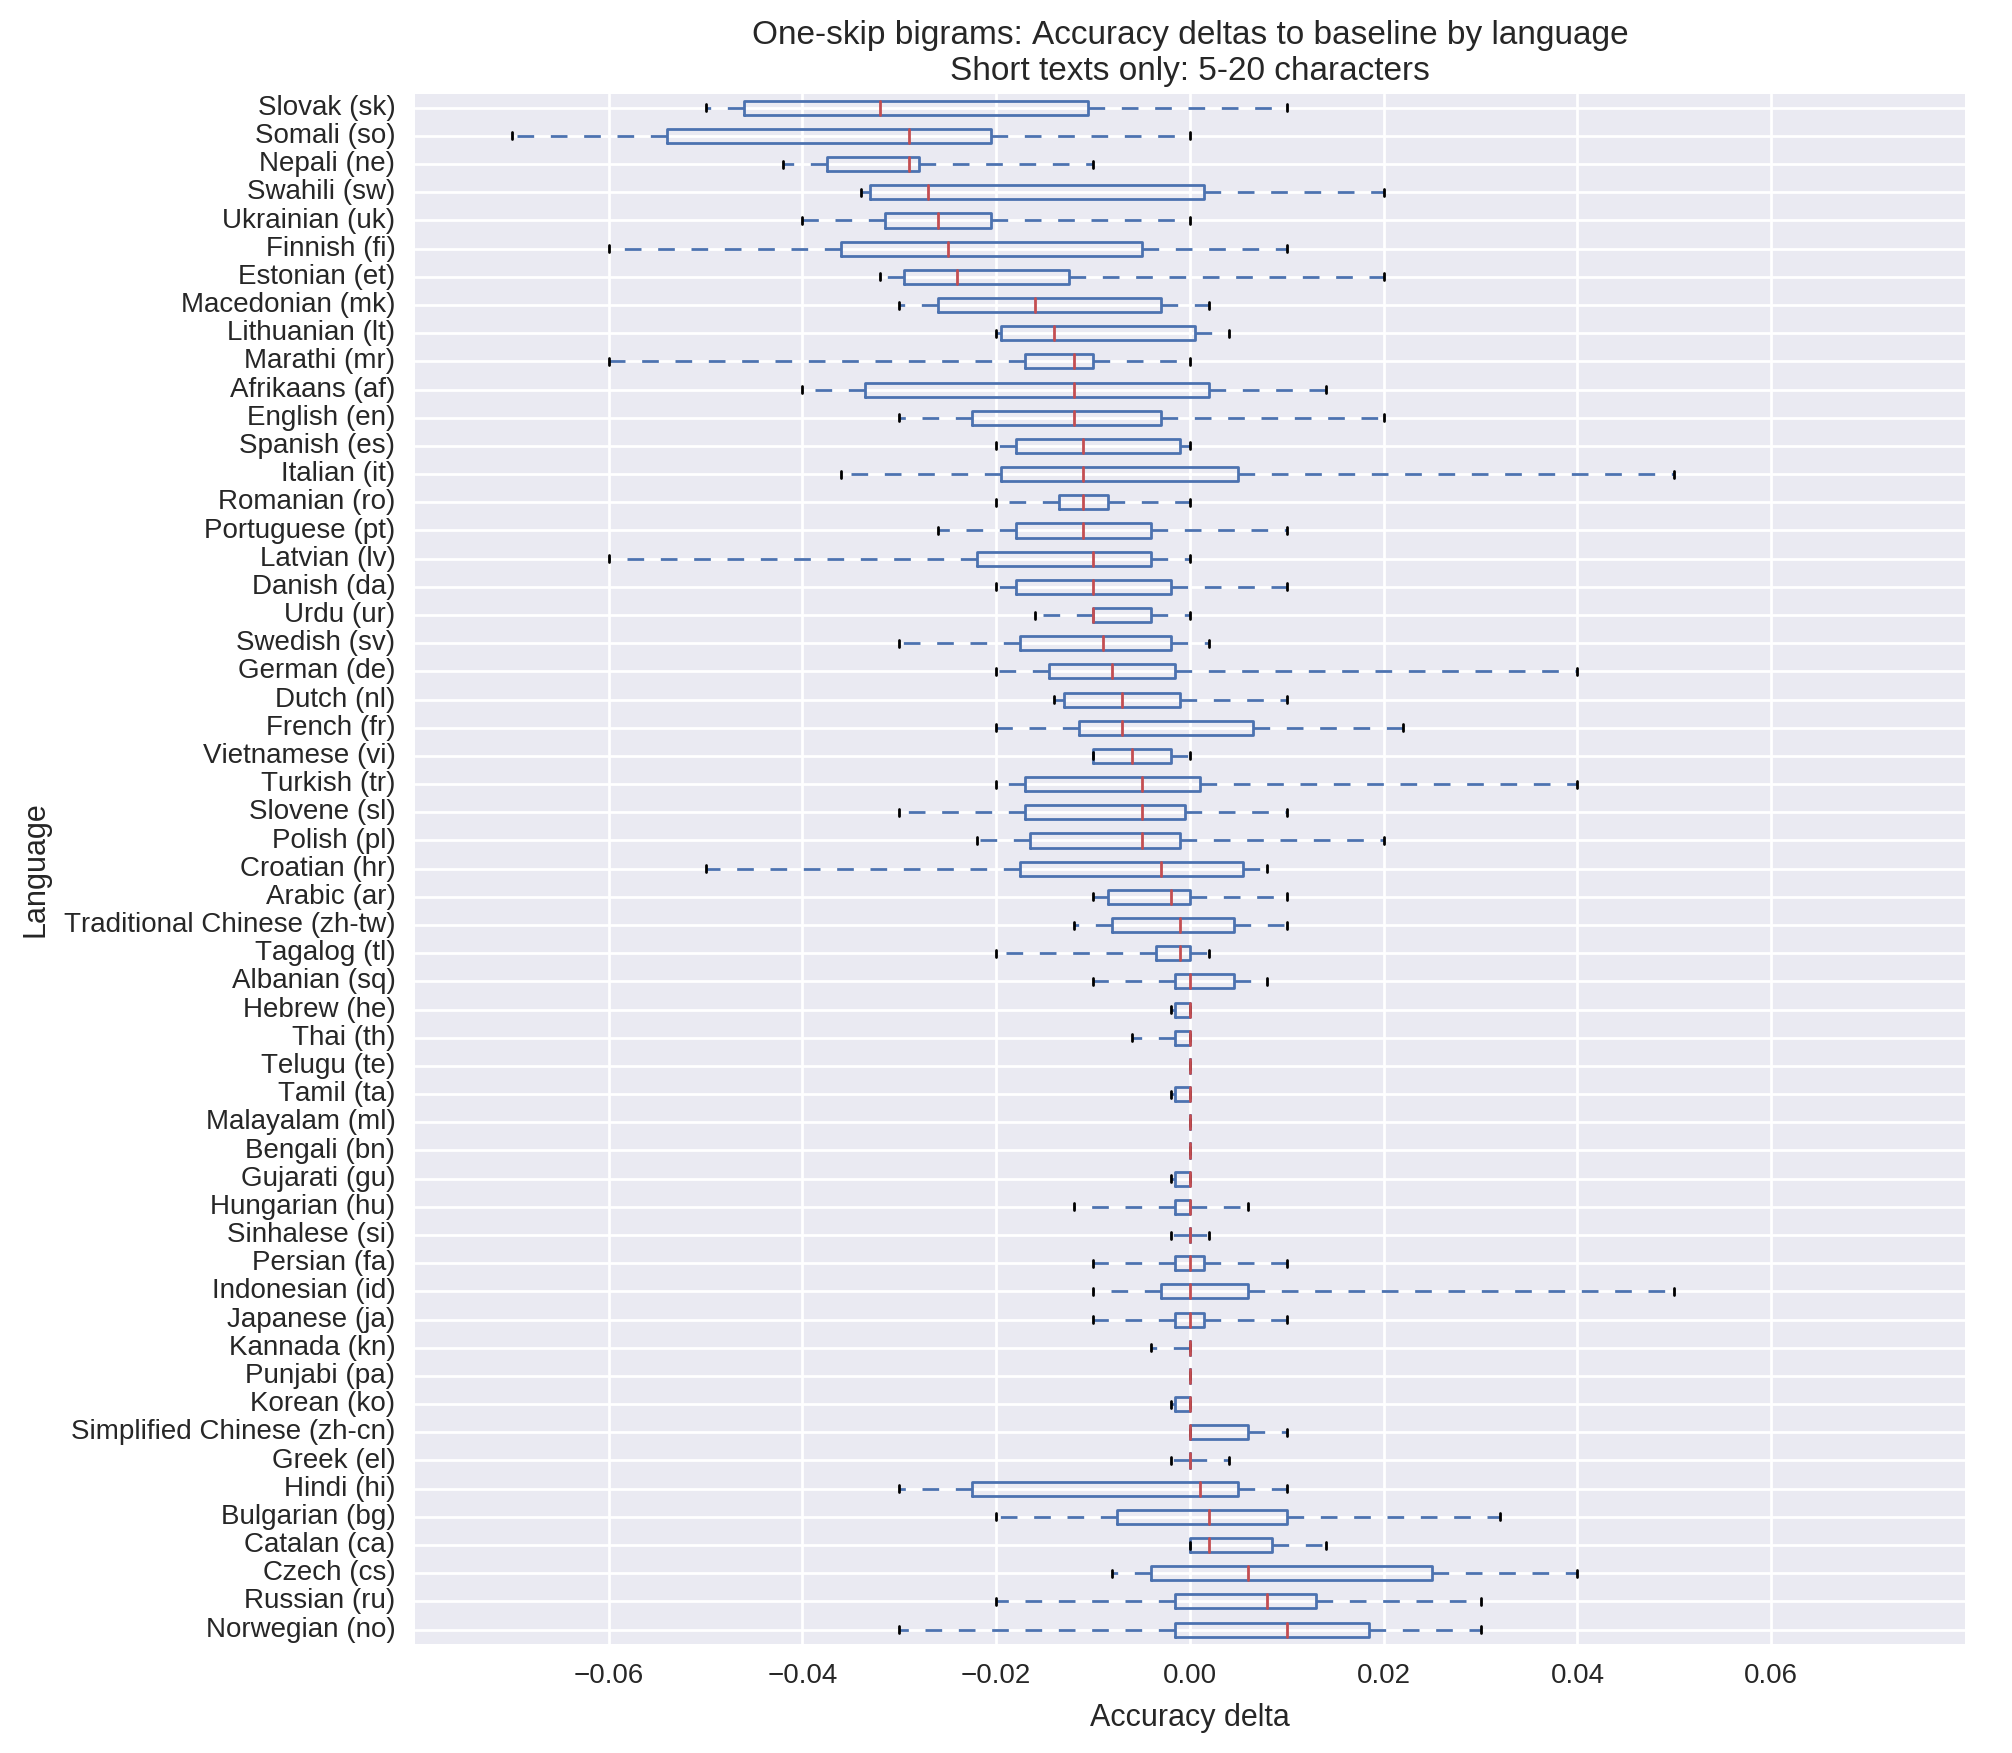

In [10]:
one_skip_bigrams_results = read_results('results/one-skip-bigrams.csv')
plot_accuracy_deltas_by_language(baseline_results,
                                 one_skip_bigrams_results,
                                 'One-skip bigrams:')

## Experiment: normalizer-nfc

Replace ngrams with their NFC form (the form recommended by W3C) using the built-in [Java Normalizer](https://docs.oracle.com/javase/7/docs/api/java/text/Normalizer.html). This doesn't do much, possibly because the texts are already in NFC form. However, it'd make sense to include NFC conversion if the profiles are regenerated.

In [11]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=normalizer-nfc \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/normalizer-nfc.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 27.474 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: -0.000018


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,1,0.003030,1,0.018182
positive,2,0.006061,2,0.036364
zero,327,0.990909,52,0.945455


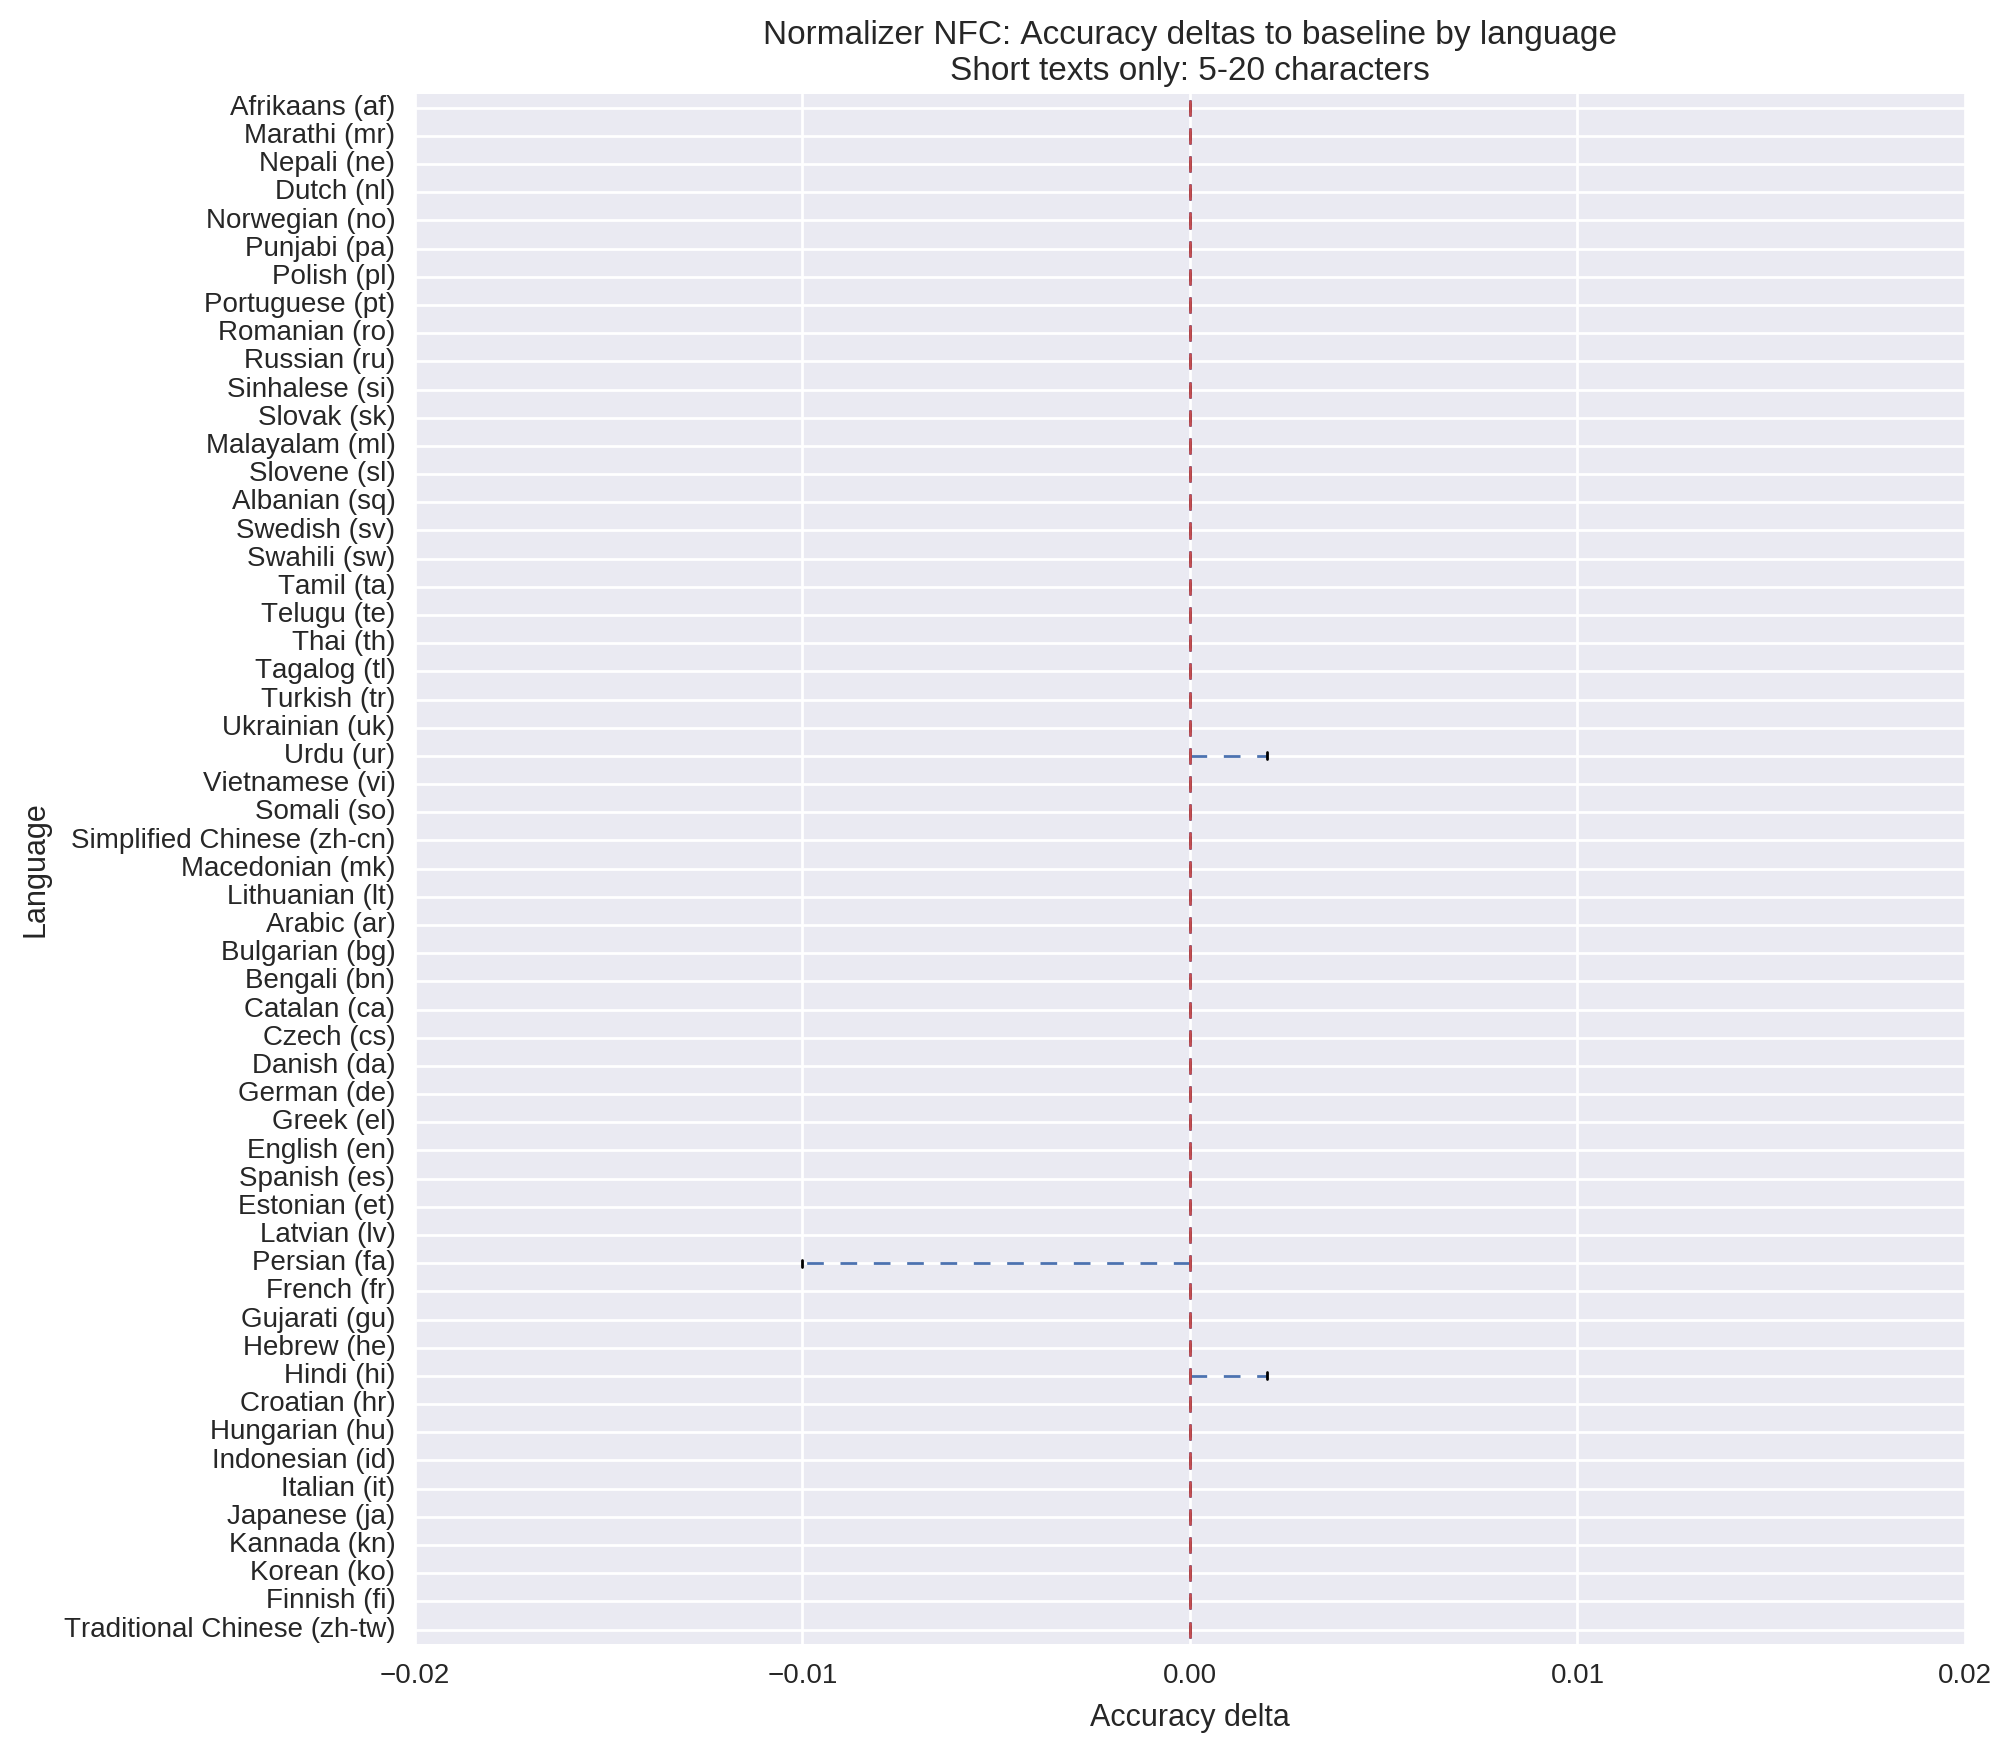

In [12]:
normalizer_nfc_results = read_results('results/normalizer-nfc.csv')
plot_accuracy_deltas_by_language(baseline_results, normalizer_nfc_results, 'Normalizer NFC:')

## Pseudo-experiment: confusion-matrix

Some languages are more likely to be confused than others. This "experiment" outputs the full confusion matrix for analysis.

In [13]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=confusion-matrix \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/confusion-matrix.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 25.271 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


In [14]:
def read_confusion_matrix(dataset_name, substring_length, path='results/confusion-matrix.csv'):
    df = pd.read_csv(path)
    df = df[(df['datasetName'] == dataset_name) & (df['substringLength'] == substring_length)]
    assert len(df) == 55
    df.drop(RESULT_PARAM_COLS, axis=1, inplace=True)
    df.set_index('actual', inplace=True)
    for axis in (0, 1):
        df.rename_axis({k: '{} ({})'.format(v, k) for k, v in LANGUAGE_CODE_TO_NAME.items()},
                       axis=axis, inplace=True)
    return df / df.sum(axis=1).iloc[0]

confusion_matrix = read_confusion_matrix('wordpress-translations', substring_length=5)
confusion_matrix.head().T.head().T

,null,Afrikaans (af),Arabic (ar),Bulgarian (bg),Bengali (bn)
actual,,,,,
Afrikaans (af),0.000,0.258,0.000,0.000,0.000
Arabic (ar),0.002,0.002,0.816,0.000,0.000
Bulgarian (bg),0.004,0.002,0.000,0.384,0.000
Bengali (bn),0.002,0.000,0.000,0.000,0.974
Catalan (ca),0.004,0.018,0.000,0.000,0.000


Example: What are the top languages predicted for Norwegian, Danish & Swedish WP texts of length 5 (the hardest dataset)?

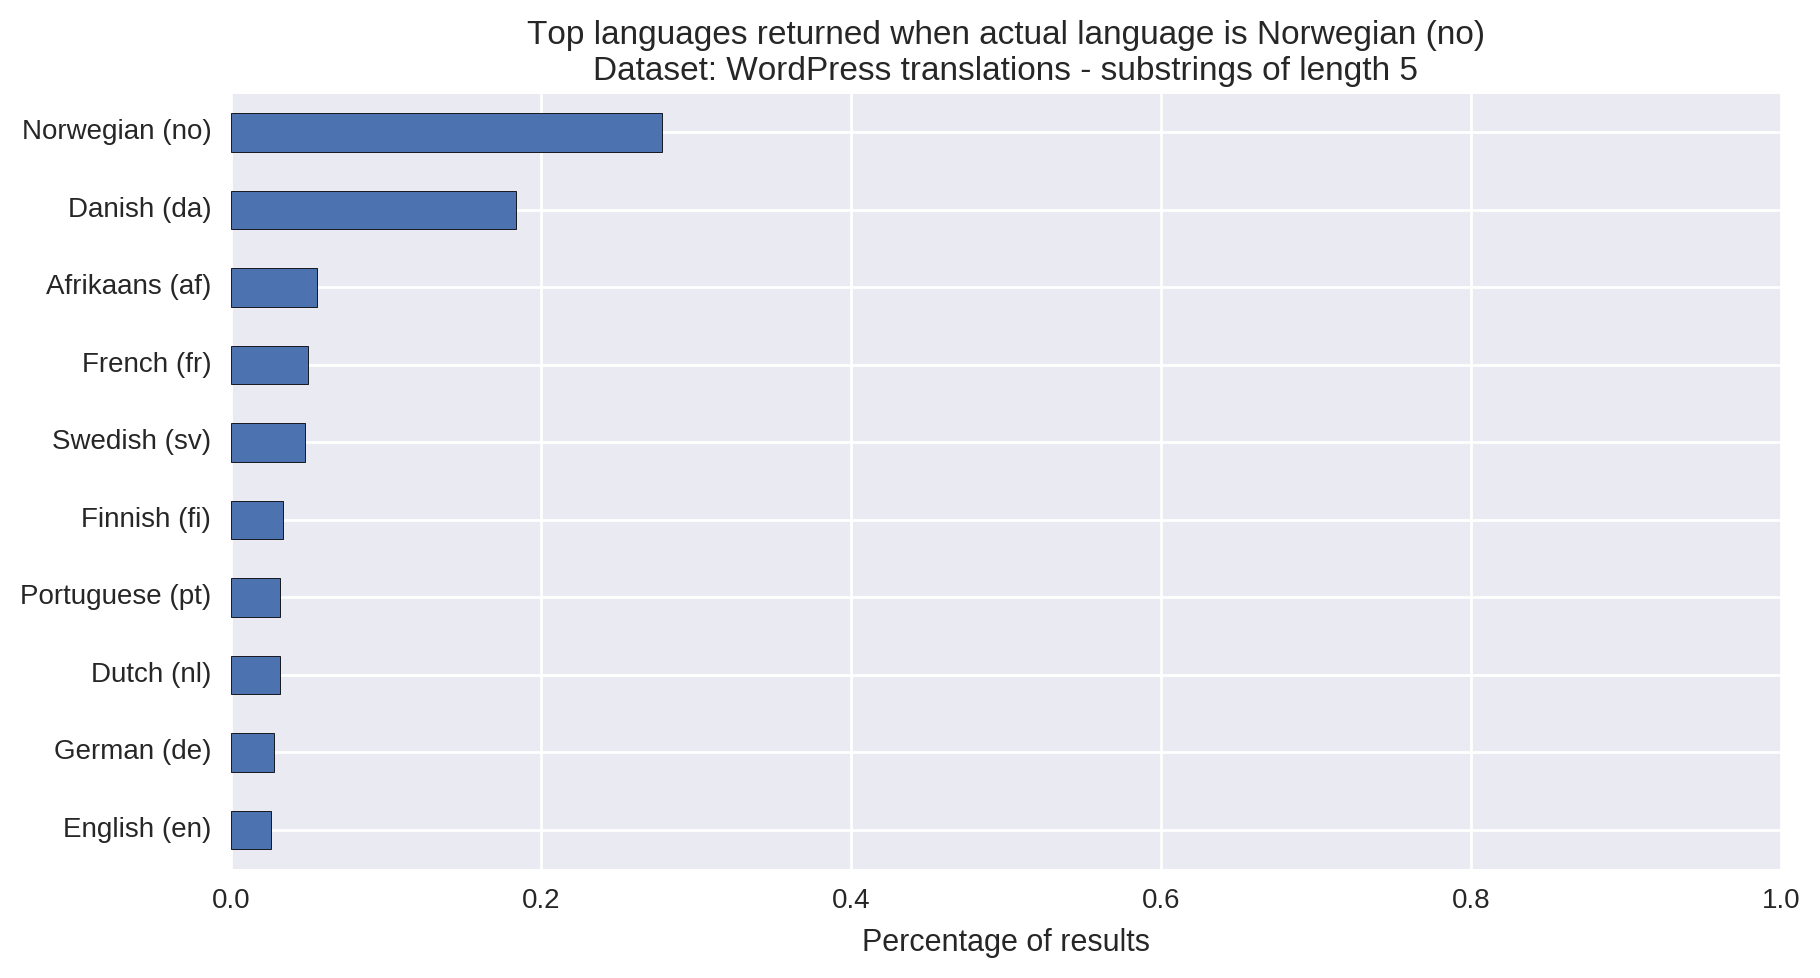

In [15]:
def plot_top_confused_languages(confusion_matrix, actual_language, num_top=10,
                                dataset_name='WordPress translations - substrings of length 5'):
    ax = confusion_matrix.ix[actual_language].sort_values()[-num_top:].plot.barh()
    ax.set_xlim((0, 1))
    ax.set_title('Top languages returned when actual language is {}\nDataset: {}'.format(actual_language,
                                                                                         dataset_name))
    ax.set_xlabel('Percentage of results')

plot_top_confused_languages(confusion_matrix, 'Norwegian (no)')

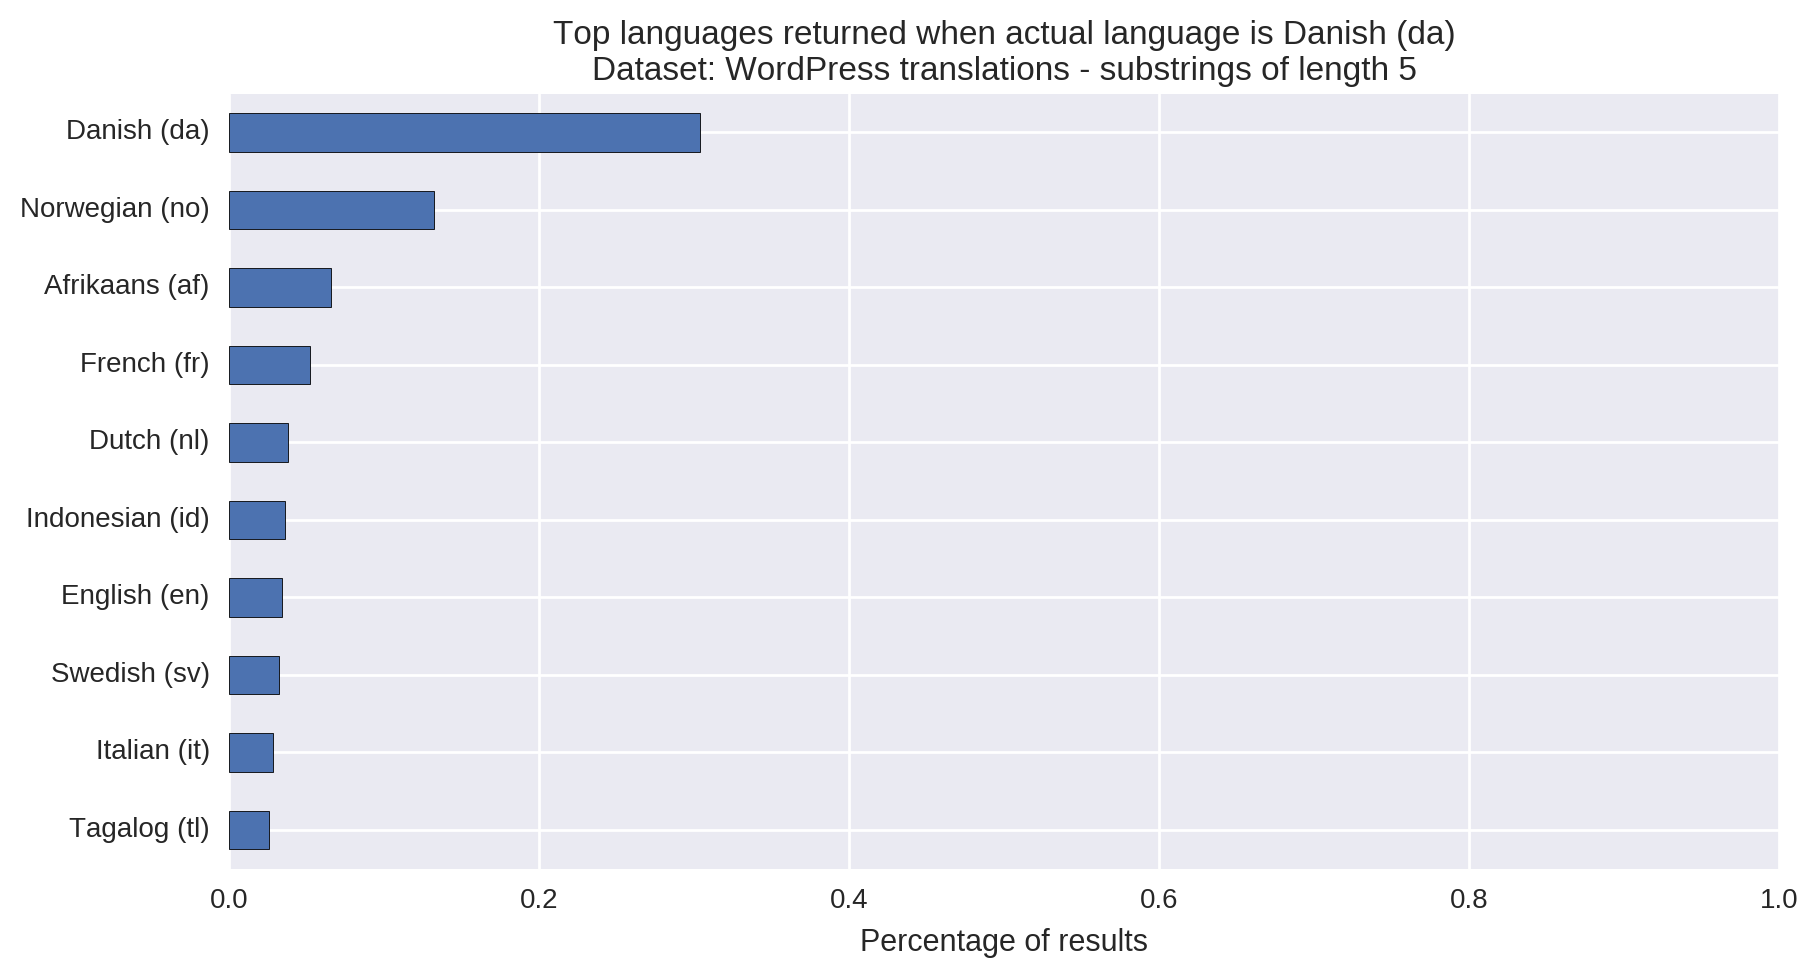

In [16]:
plot_top_confused_languages(confusion_matrix, 'Danish (da)')

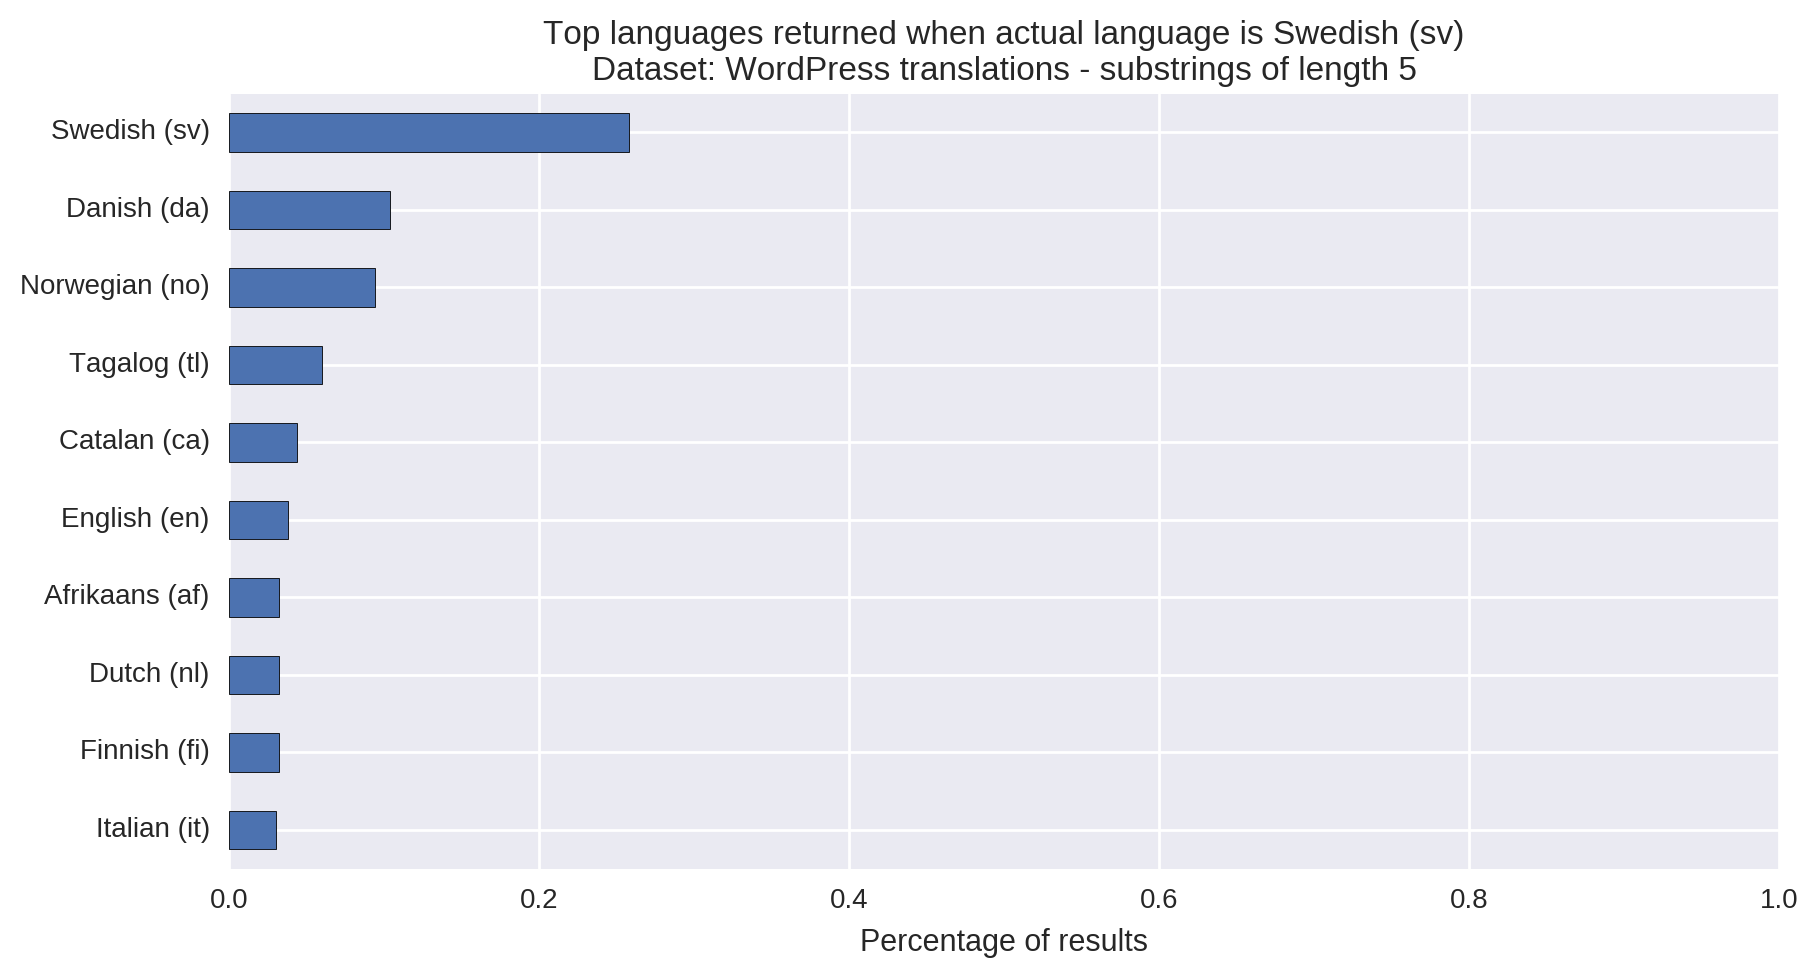

In [17]:
plot_top_confused_languages(confusion_matrix, 'Swedish (sv)')

What about Chinese?

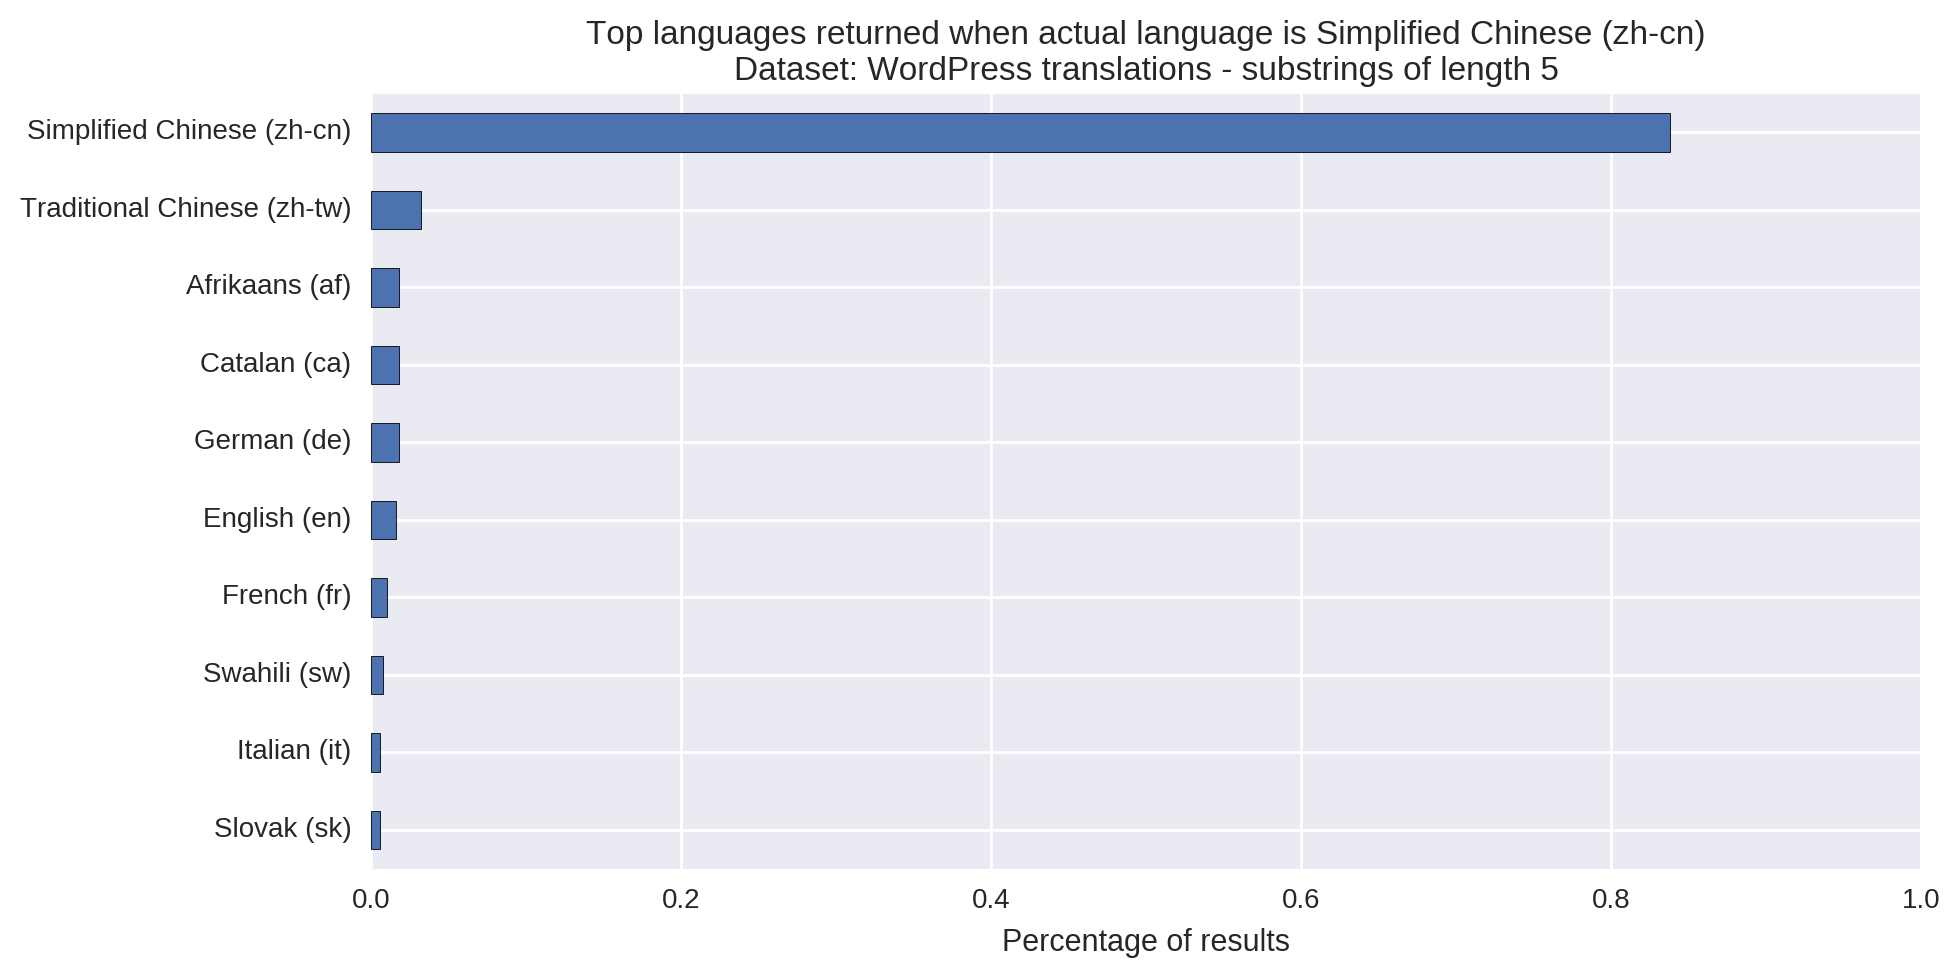

In [18]:
plot_top_confused_languages(confusion_matrix, 'Simplified Chinese (zh-cn)')

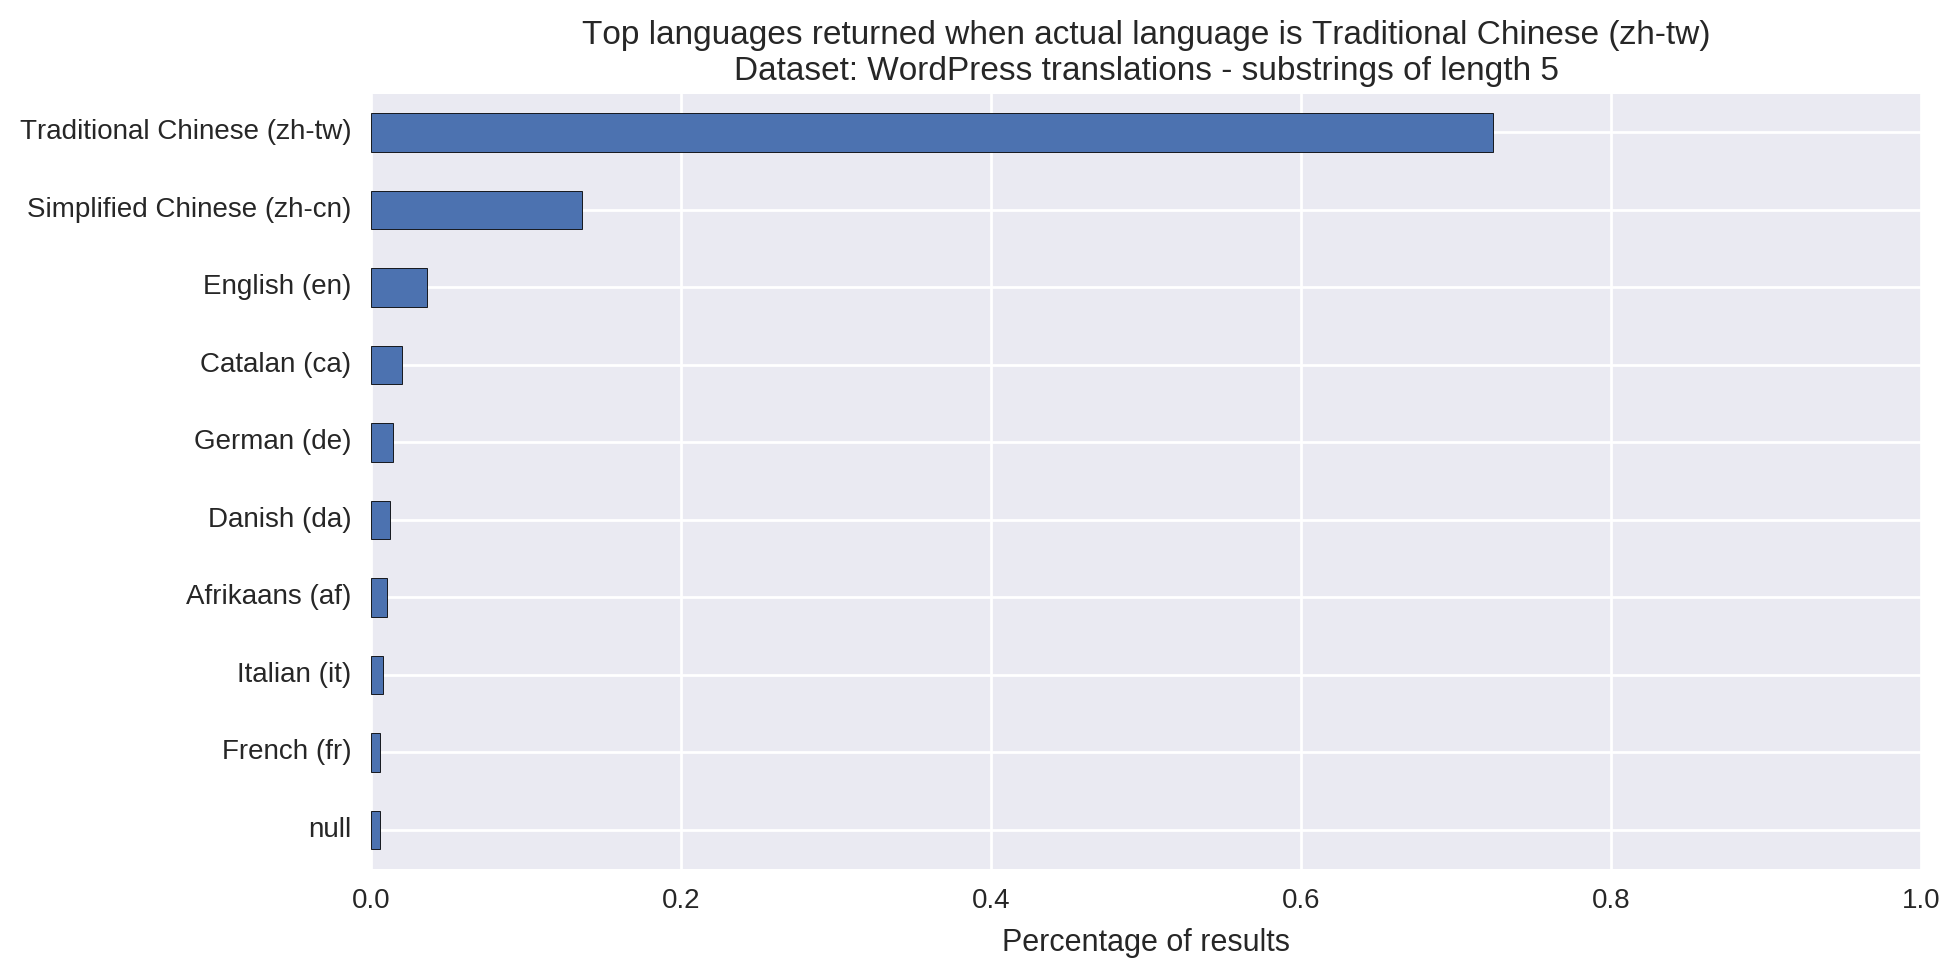

In [19]:
plot_top_confused_languages(confusion_matrix, 'Traditional Chinese (zh-tw)')

Top confused languages by actual language mostly correspond to language/script families.

In [20]:
for lang in confusion_matrix.index:
    top_confused_langs = confusion_matrix.ix[lang]
    top_confused_langs = top_confused_langs[top_confused_langs > 0.05]
    accuracy = top_confused_langs[lang]
    if accuracy > 0.9 or len(top_confused_langs) == 1:
        continue
    print(top_confused_langs.sort_values(ascending=False))
    print()

Afrikaans (af)    0.258
Dutch (nl)        0.128
Danish (da)       0.070
French (fr)       0.054
Tagalog (tl)      0.052
Name: Afrikaans (af), dtype: float64

Arabic (ar)     0.816
Persian (fa)    0.114
Name: Arabic (ar), dtype: float64

Bulgarian (bg)     0.384
Macedonian (mk)    0.376
Russian (ru)       0.134
Ukrainian (uk)     0.062
Name: Bulgarian (bg), dtype: float64

Catalan (ca)       0.240
Spanish (es)       0.114
French (fr)        0.110
Portuguese (pt)    0.084
Italian (it)       0.084
Name: Catalan (ca), dtype: float64

Czech (cs)         0.376
Slovak (sk)        0.106
Croatian (hr)      0.066
Portuguese (pt)    0.052
Name: Czech (cs), dtype: float64

Danish (da)       0.304
Norwegian (no)    0.132
Afrikaans (af)    0.066
French (fr)       0.052
Name: Danish (da), dtype: float64

German (de)       0.302
Afrikaans (af)    0.102
Dutch (nl)        0.076
Danish (da)       0.058
Name: German (de), dtype: float64

English (en)       0.338
French (fr)        0.090
Romanian (ro)     

## Experiment: ensemble-confused

This experiment uses the main classifier to find the top language. If the top language belongs to a manually-defined cluster of languages, it returns the results from another classifier that can only return one of the languages from the cluster. Otherwise, it returns the results of the main classifier.

The clusters are:
```
[
    "af,de,nl",
    "ar,fa,ur",
    "bg,mk,ru,uk",
    "ca,es,fr,pt,it",
    "cs,sk",
    "da,no,sv",
    "et,fi",
    "hi,ne,mr",
    "hr,sl",
    "id,tl",
    "lt,lv",
    "zh-cn,zh-tw"
]
```

This doesn't really help classification accuracy. It should probably be the client's job to be aware of language families.

In [21]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=ensemble-confused \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/ensemble-confused.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 33.304 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 330
Number of languages: 55
Mean delta: -0.000055


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,17,0.051515,11,0.2
positive,20,0.060606,11,0.2
zero,293,0.887879,33,0.6


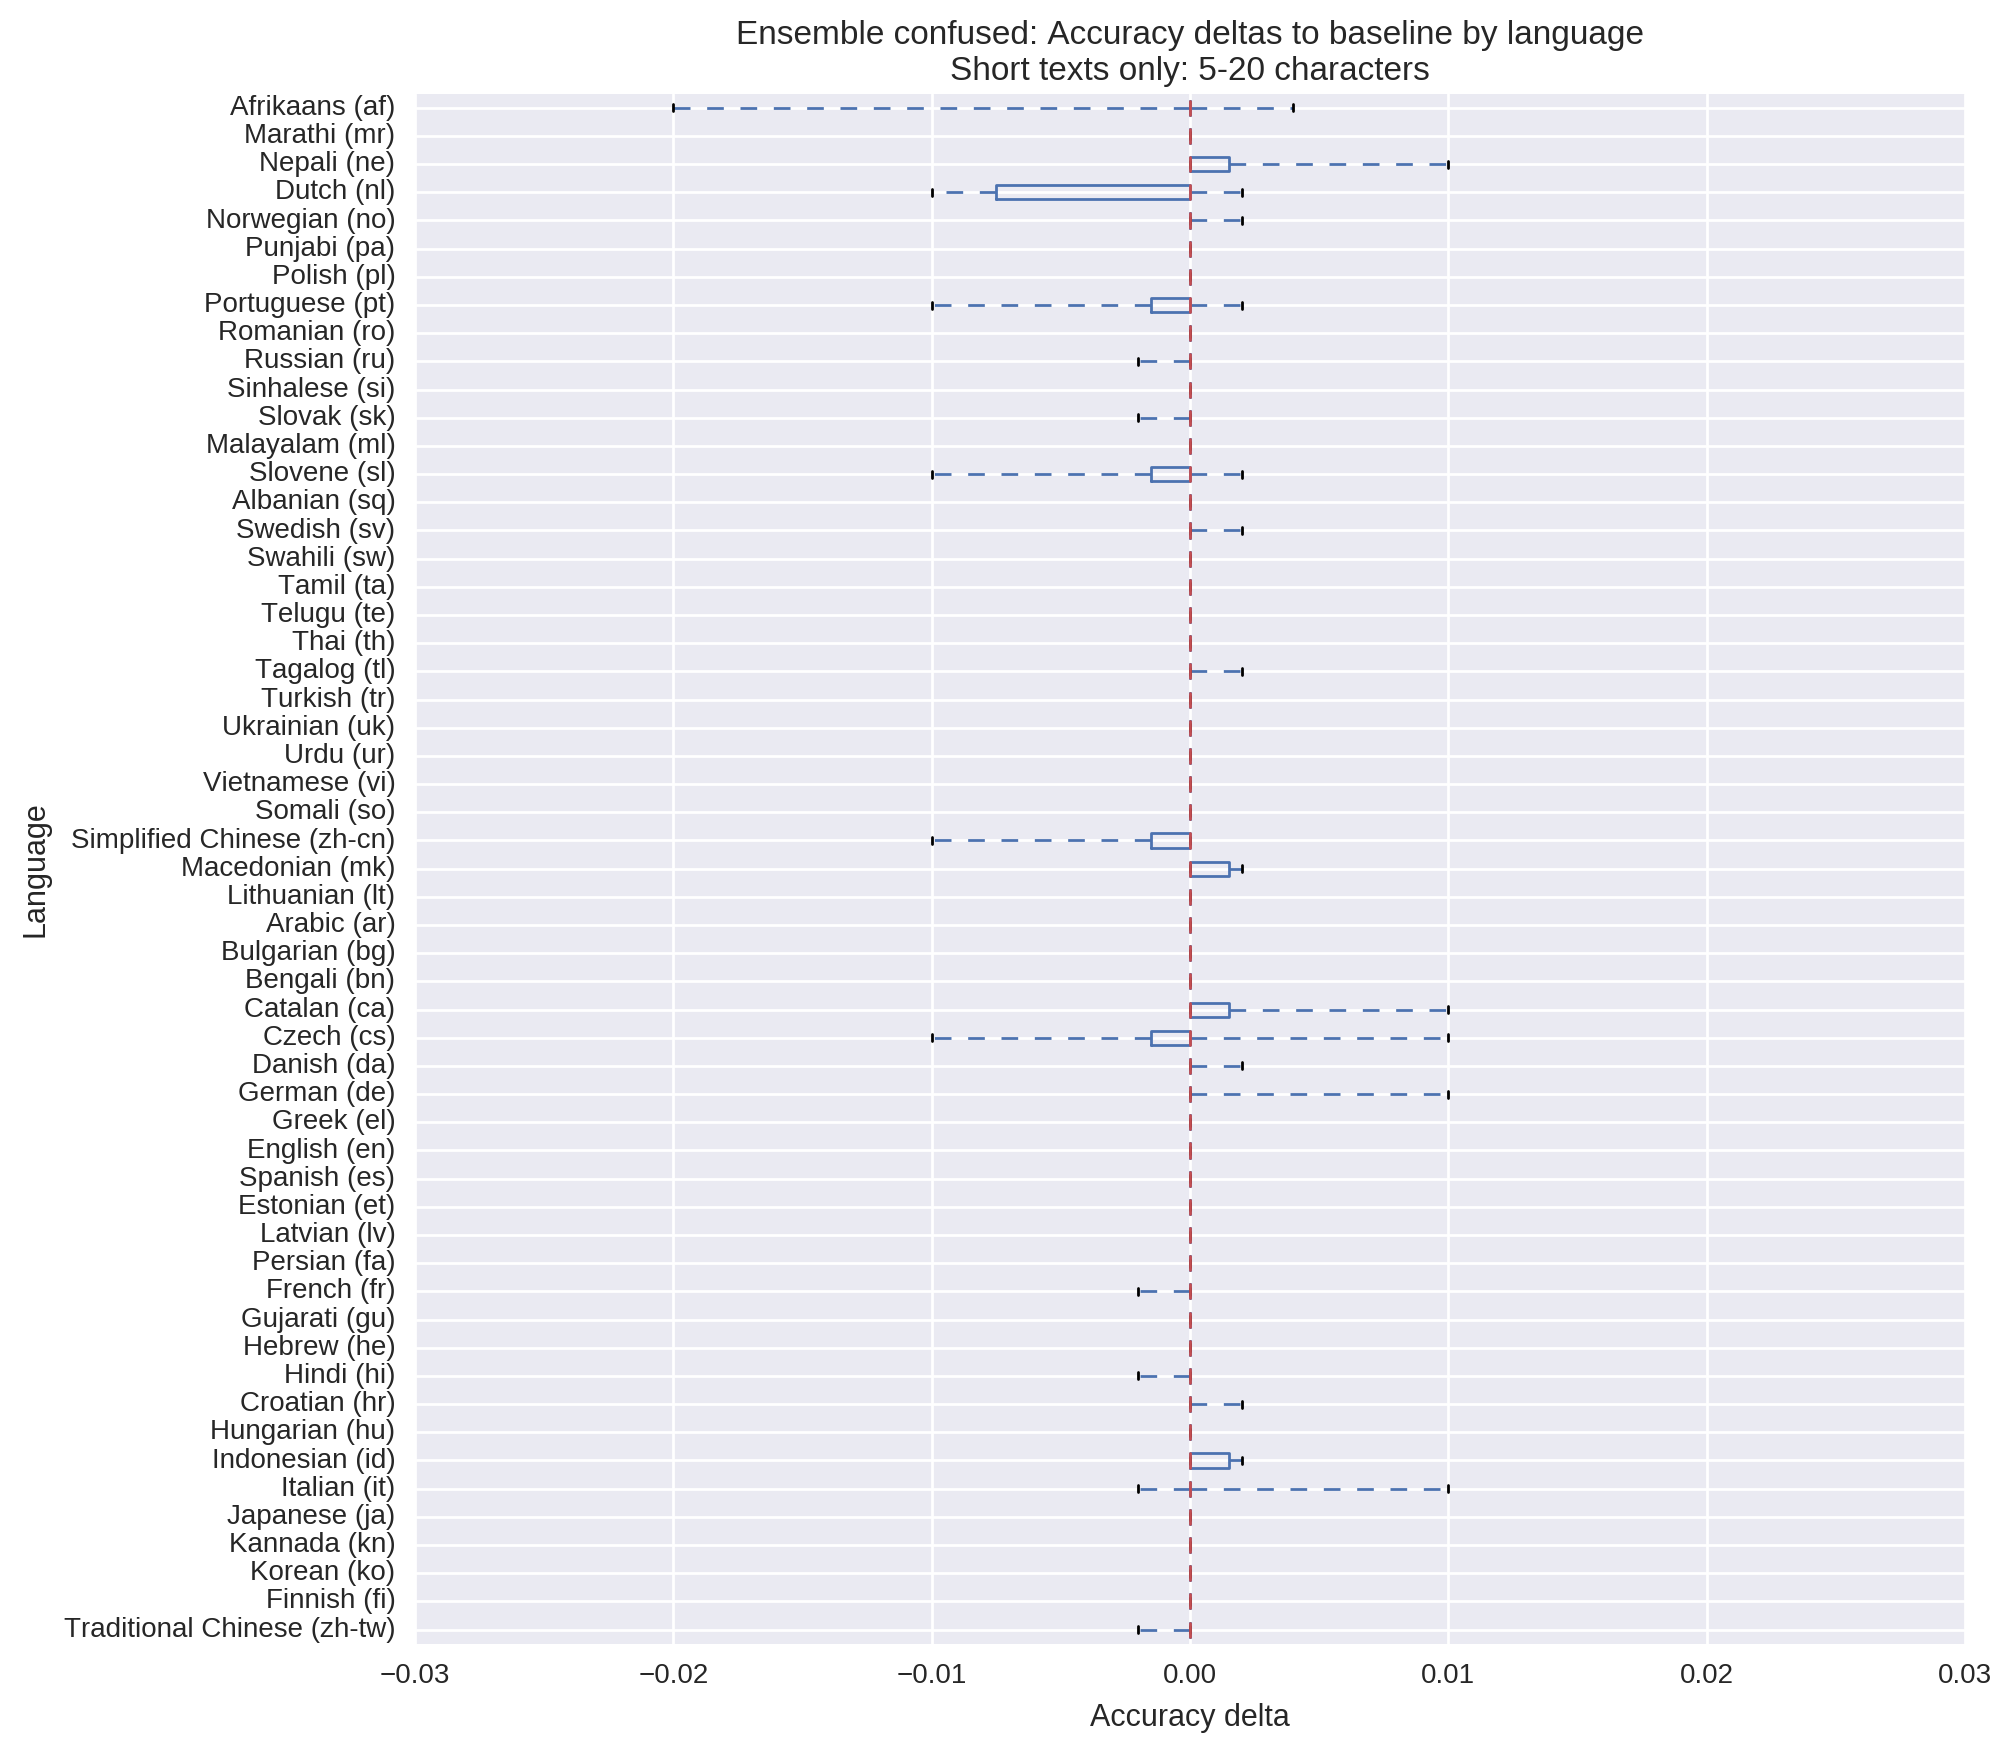

In [22]:
ensemble_confused_results = read_results('results/ensemble-confused.csv')
plot_accuracy_deltas_by_language(baseline_results, ensemble_confused_results, 'Ensemble confused:')